## План:
1. Предобработка данных:
 - Исследовать пропущенные значения;
 - Исследовать соответствие типов;
 - Исследовать дубликаты;
 - Проверить корректность наименований колонок;
 - Переименовать колонки;
 - Удалить дубликаты, если таковые есть;
 - Привести типы;
 - Заменить пропущенные значения, если необходимо.
2. Исследовательский анализ данных
3. Выделить пользователей в группы на основе нализа данных
4. Рассчитать ключевые показателей для каждой из выделенных групп и сравнить по этим показателям группы:
 - рассчитать retention rate;
 - рассчитать время, проведённое в приложении;
 - посмотреть частоту действий;
 - рассчитать конверсию в целевое действие — просмотр контактов.
5. Проверка статистических гипотез:
 - Некоторые пользователи установили приложение по ссылке из yandex, другие — из google. Проверьте гипотезу: две эти группы демонстрируют разную конверсию в просмотры контактов;
 - Формулировка собственной гипотезы на основе данных.
6. Вывод

In [1]:
import pandas as pd
import datetime as dt
from datetime import timedelta
import time
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, Ridge
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.cluster import KMeans
import numpy as np
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import silhouette_score
import string
from string import ascii_uppercase
import math as mth
import scipy.stats as stats
from scipy import stats as st

In [2]:
mdf = pd.read_csv('/Users/kirillanosov/Desktop/Data_anal/final_project/mobile_dataset.csv')
display(mdf.head(20))
mdf.info()

In [3]:
ms = pd.read_csv('/Users/kirillanosov/Desktop/Data_anal/final_project/mobile_soures.csv')
display(ms.head())
ms.info()

На случай, если нужно будет объединять таблицы, переименуем столбцы

In [4]:
mdf.set_axis(['event_time', 'event_name', 'uid'], axis = 'columns', inplace = True)


In [5]:
ms.rename(columns = {'userId' : 'uid'}, inplace = True)

### Разберемся с форматом времени и дат.

Сначала удалим миллисекунды:

In [6]:
mdf['event_time'] = pd.to_datetime(mdf['event_time'])


In [7]:
mdf['event_time'] = mdf['event_time'].dt.strftime('%Y-%m-%d %H:%M:%S')


In [8]:
mdf['event_time'] = pd.to_datetime(mdf['event_time'], errors='coerce')

mdf.info()

### Исследуем пропущенные значения:

In [9]:
mdf.isna().sum()


In [10]:
ms.isna().sum()

Убедимся, что в таблицах одинаковое количество пользователей

In [11]:
mdf['uid'].nunique(), ms['uid'].nunique()

# 2. Исследовательский анализ данных


Найдем время совершения первого действия в приложении (нам это может понадобиться в дальнейшем):

In [12]:
first_active = mdf.groupby(['uid'])['event_time'].min()
first_active.name = 'first_activity_time'
mdf1 = mdf.merge(first_active, on = 'uid')

mdf1


In [13]:
mdf1['event_date'] = mdf1['event_time'].dt.date
mdf1['first_activity_date'] = mdf1['first_activity_time'].dt.date

In [14]:
mdf1['age'] = (mdf1['event_date'] - mdf1['first_activity_date']).dt.days + 1
mdf1.head()


In [15]:
mdf1['event_date'] = pd.to_datetime(mdf1['event_date'])
mdf1['first_activity_date'] = pd.to_datetime(mdf1['first_activity_date'])

In [16]:
mdf1['first_activity_date'].value_counts(), mdf1['event_date'].value_counts()

Найдем неделю, когда произошло первое дейтсвие, и неделю, когда случались последующие активности:

In [17]:
mdf1['activity_week'] = pd.to_datetime(mdf1['event_date'], unit='d') - pd.to_timedelta(mdf1['event_date'].dt.dayofweek, unit='d')
mdf1['first_activity_week'] = pd.to_datetime(mdf1['first_activity_date'], unit='d') - pd.to_timedelta(mdf1['first_activity_date'].dt.dayofweek, unit='d')


Теперь найдем срок жизни каждой когорты и приведем ее к типу целых чисел:

In [18]:
mdf1['cohort_lifetime'] = mdf1['activity_week'] - mdf1['first_activity_week']
mdf1['cohort_lifetime'] = mdf1['cohort_lifetime'] / np.timedelta64(1,'W')
mdf1['cohort_lifetime'] = mdf1['cohort_lifetime'].astype('int') 


Посмотрим распределение активности по дням:

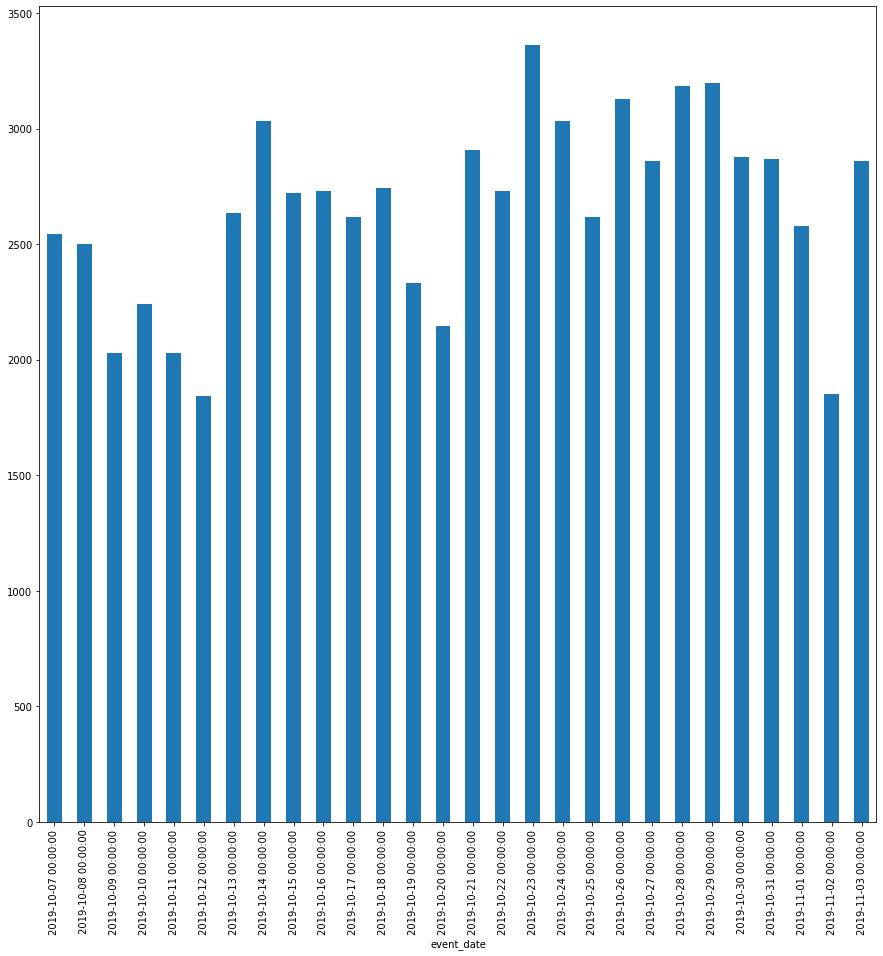

In [19]:
event_cnt = mdf1.groupby('event_date')['event_name'].count()
event_cnt.plot(kind = 'bar', figsize = (15,15))


Явных проседаний по активности пользователей нет

Найдем уникальные сессии каждого пользователя. За шаг между сессиями возьмем 15 минут, т.к. пользователи вряд ли будут задерживаться на одной странице в приложении так долго:

In [20]:
cond1 = mdf1['event_time'] - mdf1['event_time'].shift(1) > pd.Timedelta(15, 'm')
cond2 = mdf1['uid'] != mdf1['uid'].shift(1)
mdf1['session_id'] = (cond1|cond2).cumsum()

In [21]:
sess = mdf1.groupby('uid').agg({'session_id':'nunique'}).reset_index()
display(sess['session_id'].describe())
sess

In [22]:
sess['session_id'].describe()

Максимальное количесвто сессий - 116

Посчитаем длительность сессий:

In [23]:

session_min_time = mdf1.groupby(['session_id'])['event_time'].min()
session_max_time = mdf1.groupby(['session_id'])['event_time'].max()
session_min_time.name = 'session_min_time'
session_max_time.name = 'session_max_time'
mdf1 = mdf1.merge(session_min_time, on = 'session_id')
mdf1 = mdf1.merge(session_max_time, on = 'session_id')
mdf1.head()

In [24]:
mdf1['session_lifetime'] = mdf1['session_max_time'] - mdf1['session_min_time']
mdf1['session_lifetime']

Посчитаем сколько действий было выполнено пользователями:

In [25]:
events = mdf1.groupby('event_name').agg({'uid':'nunique'}).reset_index().sort_values(by = 'uid', ascending = False)
events.rename(columns = {'uid' : 'num_users'}, inplace = True)
events

Переименуем contacts_show в show_contacts, чтобы было одинаковое название

In [26]:
mdf1['event_name'] = mdf1['event_name'].replace(['contacts_show'],'show_contacts')
events = mdf1.groupby('event_name').agg({'uid':'nunique'}).reset_index().sort_values(by = 'uid', ascending = False)
events.rename(columns = {'uid' : 'num_users'}, inplace = True)
events

Посчитаем, сколько действий на одного пользователя :

In [27]:
per_user = mdf1.groupby('uid').agg({'event_name':'count'}).reset_index()
per_user['event_name'].describe()

Медианное количесвто действий - 9, среднее - 17. Есть и аномалии вроде 478 действий. Минимум 1 действие делал каждый

Рассчитаем процент действий:

In [28]:
events['prt'] = events['num_users'] / 4293 * 100
events['prt'] = events['prt'].apply(np.ceil)

events

Только 66% пользователей видят рекомендованные объявления. Было бы интересно сравнить их поведение с теми, кто этих объявлений не видит. Например, сравнить кто чаще пользуется поиском

# 3. Выделим пользователей в группы на основе нализа данных

In [29]:
tips_see = mdf1.query('event_name == "tips_show"')
tips = tips_see['uid']
saw_tips = mdf1.query('uid in @tips')

In [30]:
saw_tips['uid'].nunique()

In [31]:
saw_id = saw_tips['uid']

In [32]:
saw_part = saw_tips.groupby('event_name').agg({'uid':'nunique'}).reset_index().sort_values(by = 'uid', ascending = False)
saw_part

In [33]:
tips_not_see = mdf1.query('uid not in @saw_id')
tips_not_see['uid'].nunique()

In [34]:
tips_e = tips_not_see.groupby('event_name').agg({'uid':'nunique'}).reset_index().sort_values(by = 'uid', ascending = False)
tips_e

In [35]:
tips_see_sess = saw_tips.groupby('uid').agg({'session_id':'nunique'}).reset_index()
tips_see_sess.describe()

In [36]:
tips_not_see_sess = tips_not_see.groupby('uid').agg({'session_id':'nunique'}).reset_index()
tips_not_see_sess.describe()

Количество сессий на 1 человека среди тех, кто не видит рекомендованные объявления, выше, чем для тех, кто видит. Интересно будет сравнить основные показатели этих двух групп: retention rate, время в приложении, конверсию в целевое действие и частоту действий. **Возьмем их за отправную точку**:

In [37]:
part1 = tips_not_see
part2 = saw_tips

Посмотрим, сколько и какие действия совершали члены группы, которой не показывали рекомендации:

In [38]:
part1_actions = part1.groupby('event_name').agg({'uid':'nunique'}).reset_index().sort_values(by = 'uid', ascending = False)
part1_actions

Бросается в глаза, что среди тех, кому рекомендации не показывают, очень много людей пользуются поиском. Но есть те, кому он не нужен. Это будут **первые две группы**:

In [39]:
searches1 = part1.query('event_name == ("search_1","search_2", "search_3", "search_4", "search_5", "search_6", "search_7")')
uid1 = searches1['uid']
group1 = part1.query('uid in@uid1').reset_index()
group1['uid'].nunique()

In [40]:

group2 = part1.query('uid not in@uid1').reset_index()
group2['uid'].nunique()


Аналогично поступим с частью пользователей, которой рекомендации показывали:

In [41]:
part2_actions = part2.groupby('event_name').agg({'uid':'nunique'}).reset_index().sort_values(by = 'uid', ascending = False)
part2_actions

Тут тоже пользователи часто пользовадись поиском. Тоже поделим их на тех, кто пользовался и тех, кто не пользовался. **Это будут группы 3 и 4**:

In [42]:
searches2 = part2.query('event_name == ("search_1","search_2", "search_3", "search_4", "search_5", "search_6", "search_7")')
uid2 = searches2['uid']
group3 = part2.query('uid in@uid2').reset_index()
group3['uid'].nunique()

In [43]:
group4 = part2.query('uid not in@uid2')
group4['uid'].nunique()

# 4. Рассчет ключевых метрик в группах

### Рассчитаем retention rate

 Напишем функцию, которая выведет рейтинг удержания клиентов для всех 4 групп:

In [44]:
def retention(data):
    cohorts = data.groupby(['first_activity_week','cohort_lifetime']).agg({'uid':'nunique'}).reset_index()
    initial_users = cohorts[cohorts['cohort_lifetime'] == 0][['first_activity_week','uid']]
    initial_users = initial_users.rename(columns={'uid':'cohort_users'}) 
    cohorts = cohorts.merge(initial_users,on='first_activity_week')
    cohorts['retention'] = cohorts['uid']/cohorts['cohort_users']
    retention_pivot = cohorts.pivot_table(index='first_activity_week',columns='cohort_lifetime',values='retention',aggfunc='sum')
    sns.set(style='white')
    plt.figure(figsize=(13, 9))
    plt.title('Cohorts: User Retention')
    sns.heatmap(retention_pivot, annot=True, fmt='.1%', linewidths=1, linecolor='gray')

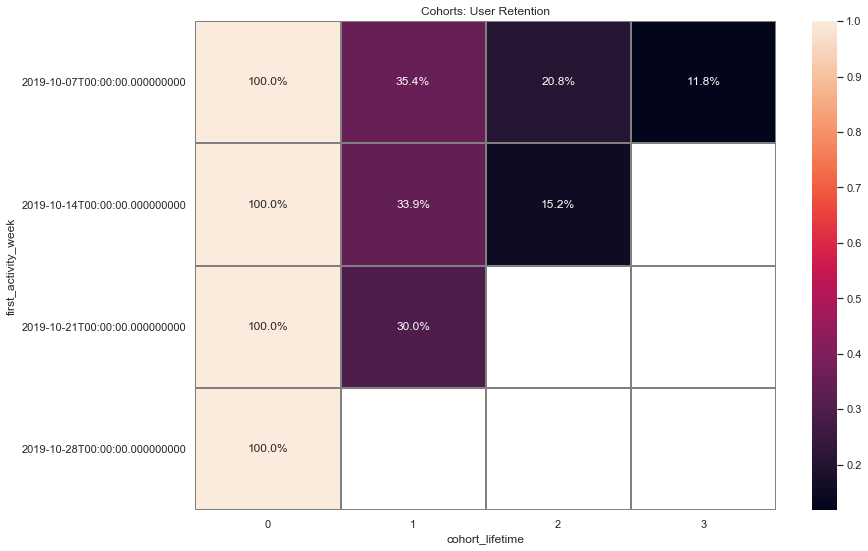

In [45]:
retention(group1)

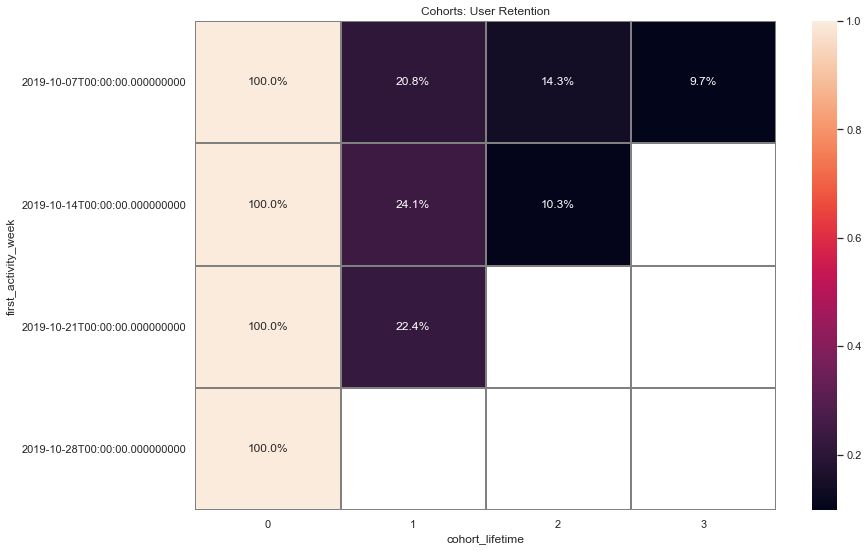

In [46]:
retention(group2)

**Группа 1(не видят рекомендаций и пользуются поиском)** показывают достойные 30% - 34% удержания на второй неделе, но к четвертой неделе первая когорта падает до 11.8%. Вторая когорта с 33% на второй неделе падает до 15% на третей. Это говорит о том, что все-таки эта аудитория на долго не задерживается.

**Группа 2(не видят рекомендаций и не пользуются поиском)** показывает результат хуже, чем группа 1: от 20% до 24% удержания клиентов на второй неделе. К четвертой неделе первая когорта падает до 9.7%, а вторая когорта к третей неделе до 10.3%. Результаты в общем не очень хорошие.


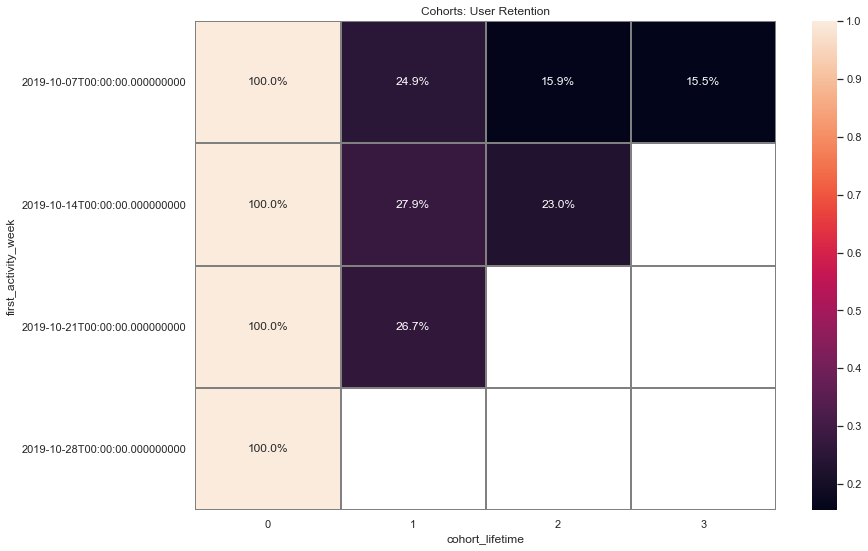

In [47]:
retention(group3)

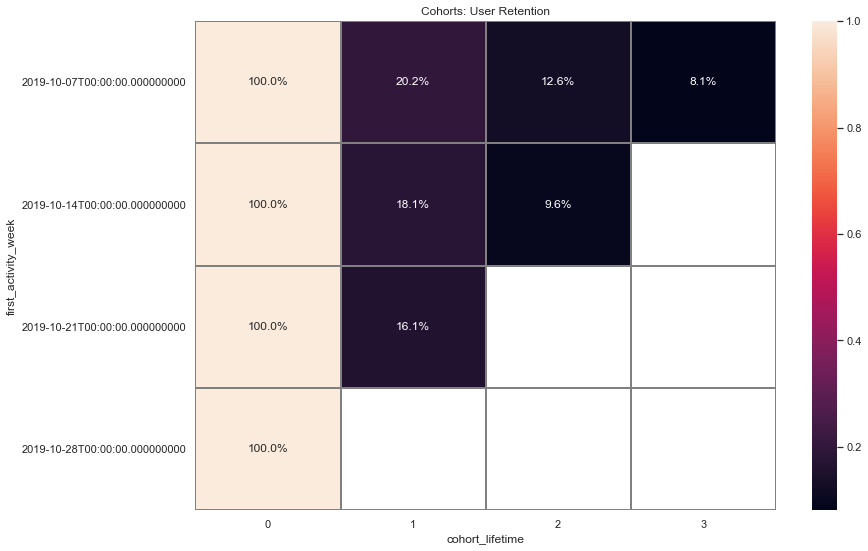

In [48]:
retention(group4)

**Группа 3(видят рекомендации и пользуются поиском)** показывает не самые высокие проценты удержания, но самые стабильные. Первая когорта на второй неделе имеет 24.9%, потом этот показатель падает до 15.9% на третей, но к четвертой неделе показатель теряет всего 0.4%. Вторая когорта тожа очень стабильна.

**Группа 4(видят рекомендации и не пользуются поиском)** показывает худщие результаты среди всех групп

### Рассчитаем время, проведённое в приложении

Создадим новую табличку gh с показателями времени жизни какждой сессии пользователей:

In [49]:
session_min_time = mdf1.groupby(['session_id'])['event_time'].min().reset_index()
session_max_time = mdf1.groupby(['session_id'])['event_time'].max().reset_index()
session_min_time.name = 'session_min_time'
session_max_time.name = 'session_max_time'
gh = session_min_time.merge(session_max_time, on = 'session_id')
gh['lifetime'] = gh['event_time_y'] - gh['event_time_x']
gh = gh.drop(['event_time_x', 'event_time_y'], axis = 1)


Напишем функцию для всех групп, которая позволит рассчитать время, проведенное в приложении:

In [50]:
def lifetime(data):
    time_in_app = data.groupby(['uid', 'session_id']).agg({'session_lifetime':'sum'}).reset_index()
    time_in_app = time_in_app.merge(gh, on = 'session_id')
    time_in_app = time_in_app.groupby('uid').agg({'lifetime':'sum'})
    print(time_in_app['lifetime'].describe())
    display(time_in_app)

In [51]:
lifetime(group1)

In [52]:
lifetime(group2)

Из-за наличия серьезных выбросов будем смотреть не среднюю, а медиану. В **группе 1(не видят рекомендаций и пользуются поиском)** медианное время в приложении составляет почти 12 минут. В **группе 2(не видят рекомендаций и не пользуются поиском)** медианное время составило 7.5 минут.

In [53]:
lifetime(group3)

In [54]:
lifetime(group4)

В **группе 3(видят рекомендации и пользуются поиском)** медианное время в приложении почти 18 минут. В **группе 4(видят рекомендации и не пользуются поиском)** медианное время 14 минут.

**Общий вывод**:

В целом те, кто видят рекомендации, проводят в приложении больше времени. И те, кто использует поиск, тоже в приложении проводят больше времени

### Посмотрим частоту действий пользователей в группах

Построим функцию, которая рассчитает все показатели частоты действий для всех групп:

In [55]:
def actions(data):
    dau_total = data.groupby('event_date').agg({'uid': 'nunique'}).mean()
    wau_total = data.groupby('activity_week').agg({'uid': 'nunique'}).mean()
    sticky_wau = dau_total/wau_total * 100
    print('Уникальное колтичество пользователей в день:', dau_total)
    print('Уникальное колтичество пользователей в неделю:', wau_total)
    print('Как часто обращались к приложению:', sticky_wau)

**Группа 1**:

In [56]:
actions(group1)

**Группа 2**:

In [57]:
actions(group2)

В **группе 1(не видят рекомендаций и пользуются поиском)** 64 уникальных пользователей в день, 301 в неделю. Пользователи первой группы обращаются к приложению в неделю 21 раз.

В **группе 2(не видят рекомендаций и не пользуются поиском)** 40 уникальных пользователей в день, 198 в неделю. Пользователи второй группы обращаются к приложению 20 раз в неделю

**Группа 3**:

In [58]:
actions(group3)

**Группа 4**:

In [59]:
actions(group4)

В **группе 3(видят рекомендации и пользуются поиском)** 58 ункиальных пользователей в день и 272 в неделю. Пользователи третей группы обращаются к приложению 21 раз в неделю

В **группе 4(видят рекомендации и не пользуются поиском)** 116 уникальных пользователя в день и 611 в неделю. Пользователи четвертой группы обращаются к приложению 19 раз неделю

**Выводы по частоте взаимодействия с приложением**:
 Значительной разницы по частоте взаиможействий с приложением в неделю между группами нет.
 

### Рассчитаем конверсию в целевое действие — просмотр контактов:

In [60]:
def conversion(data):
    events = data.groupby('event_name').agg({'uid':'nunique'}).reset_index()
    events['prt'] = events['uid'] / data['uid'].nunique() * 100
    events['prt'] = events['prt'].apply(np.ceil)
    events = events.drop('uid', axis = 1)
    
   
    events.plot(kind = 'bar', x = 'event_name', grid = True, legend = True)
    
    print(events)

**Группа 1**:

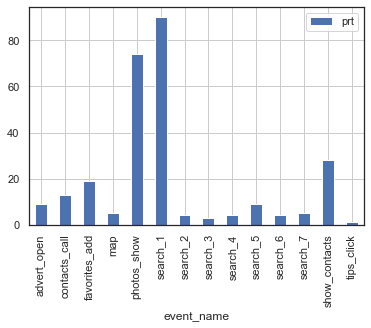

In [61]:
conversion(group1)

**Группа 2**:

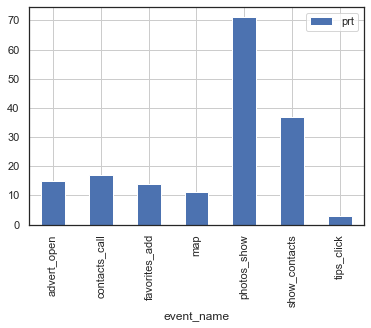

In [62]:
conversion(group2)

В **группе 1(не видят рекомендаций и пользуются поиском)** конверсия в целевую метрику show_contacts - 28%.

В **группе 2(не видят рекомендаций и не пользуются поиском)** конверсия в целевую метрику show_contacts - 37%.

**Группа 3**:

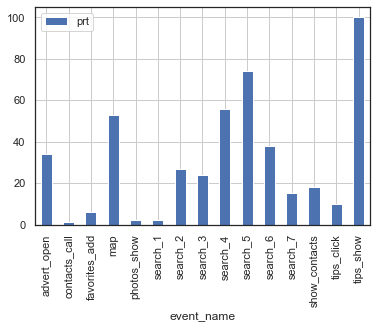

In [63]:
conversion(group3)

**Группа 4**:

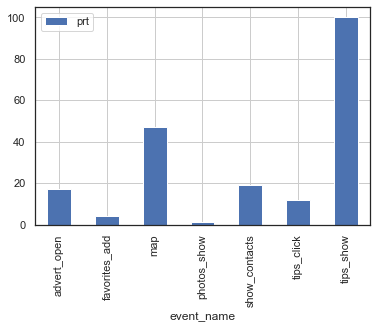

In [64]:
conversion(group4)

В **группе 3(видят рекомендации и пользуются поиском)** конверсия в целевую метрику show_contacts - 18%.

В **группе 4(видят рекомендации и не пользуются поиском)** конверсия в целевую метрику show_contacts - 19%.

**Общий вывод по конверсии в целевое действие просмотр контактов**:
 - Группы, которые не видели рекомендаций, показывают лучшую конверсию в целевую метрику show_contacts;
 - Группа 1(не видят рекомендаций и пользуются поиском) показала худший результат, чем группа 2(не видят рекомендаций и не пользуются поиском);
 - Между группой 3(видят рекомендации и пользуются поиском) и группой 4(видят рекомендации и не пользуются поиском) нет значительной разницы в конверсии.

# 5. Проверка статистических гипотез:

### Некоторые пользователи установили приложение по ссылке из yandex, другие — из google. Проверьте гипотезу: две эти группы демонстрируют разную конверсию в просмотры контактов

Для проверки гипотезы объединим две таблицы:

In [65]:
test = mdf.merge(ms, on = 'uid')
test.head()

Теперь нам надо разделить эту таблицу на две части: одну с пользователями, пришедшими из google, одну - с пользователями из yandex

In [66]:
yandex = test.query('source == "yandex"')
google = test.query('source == "google"')

In [67]:
yandex.info(), google.info()

Уже видно, что табличкa yandex больше. Посмторим распределние пользователей:

In [68]:
yandex['uid'].nunique(), google['uid'].nunique()

Из yandex пришло на 805 пользователей больше. Найдем распределения по активностям пользователей:

In [69]:
#как и у основоного датафрейма сделаем одинаковые названия для целевого действия
yandex['event_name'] = yandex['event_name'].replace(['contacts_show'],'show_contacts')
google['event_name'] = google['event_name'].replace(['contacts_show'],'show_contacts')

In [70]:
yandex = yandex.groupby('event_name').agg({'uid':'nunique'}).reset_index().sort_values(by = 'uid', ascending = False)
yandex['prt'] = yandex['uid'] / 1934 * 100
yandex['prt'] = yandex['prt'].apply(np.ceil)

yandex

In [71]:
google = google.groupby('event_name').agg({'uid':'nunique'}).reset_index().sort_values(by = 'uid', ascending = False)
google['prt'] = google['uid'] / 1129 * 100
google['prt'] = google['prt'].apply(np.ceil)

google

**25%** - именно столько пользователей из google и yandex добираются до целевого действия - show_contacts. 

Проверим это с помощью z-теста:

In [72]:
alpha = .05
successes = np.array([478, 275])
trials = np.array([1934, 1129])
p1 = successes[0]/trials[0]
p2 = successes[1]/trials[1]
p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])
difference = p1 - p2
z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))
distr = st.norm(0, 1)
p_value = (1 - distr.cdf(abs(z_value))) * 2
print('p-значение: ', p_value)
if (p_value < alpha):
    print("Отвергаем нулевую гипотезу: между долями есть значимая разница")
else:
    print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными")

Действительно, разницы нет

### Формулировка собственной гипотезы на основе данных

**Предлагаю проверить гипотезу: люди, которые провели более 3 сессий в приложении, показывают лучшую конверсию в целевую метрику**

In [73]:
session = mdf1.groupby('uid').agg({'session_id':'nunique'}).reset_index().sort_values(by = 'session_id', ascending = False)
session['session_id'].describe()

In [74]:
sess = session.query('session_id >= 3')
uid_sess = sess['uid']
session1 = mdf1.query('uid in@uid_sess').reset_index()
session1['uid'].nunique()


In [75]:
session2 = mdf1.query('uid not in@uid_sess').reset_index()
session2['uid'].nunique()

session1 - те, кто провел больше или ровно 3 сессии в приложении.

session2 - те, кто провел меньше 3 сессий в приложении.

In [76]:
session1 = session1.groupby('event_name').agg({'uid':'nunique'}).reset_index().sort_values(by = 'uid', ascending = False)
session1['prt'] = session1['uid'] / 1266 * 100
session1['prt'] = session1['prt'].apply(np.ceil)
session1

In [314]:
session2 = session2.groupby('event_name').agg({'uid':'nunique'}).reset_index().sort_values(by = 'uid', ascending = False)
session2['prt'] = session2['uid'] / 3027 * 100
session2['prt'] = session2['prt'].apply(np.ceil)
session2

Конверсия тех, кто провел больше или ровно 3 сессии в приложении, 39%. Тех, кто провел меньше 3 сессий в приложении - 17%. Проверим это с помощью z-теста:

In [77]:
alpha = .05
successes = np.array([493, 488])
trials = np.array([1266, 3027])
p1 = successes[0]/trials[0]
p2 = successes[1]/trials[1]
p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])
difference = p1 - p2
z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))
distr = st.norm(0, 1)
p_value = (1 - distr.cdf(abs(z_value))) * 2
print('p-значение: ', p_value)
if (p_value < alpha):
    print("Отвергаем нулевую гипотезу: между долями есть значимая разница")
else:
    print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными")

Действительно, те, кто проводит в приложении больше или ровно 3 сессии, показывает лучшую конверсию в целевую метрику show_contacts

# 6. Вывод:


 - Мы поделили пользователей на 4 группы: группа 1 - не видят рекомендаций и пользуются поиском; группа 2 - не видят рекомендаций и не пользуются поиском; группа 3 - видят рекомендации и пользуются поиском; группа 4 - видят рекомендаций и не пользуются поиском;
 - Самые низкие показатели удержания клиентов демонстрирует группа 4; группа 1 и 2 имеют самые высокие результаты на второй неделе; группа 3 показывает самый стабильный процент удержания, без резких падений;
 - В целом те, кто видят рекомендации, проводят в приложении больше времени. И те, кто использует поиск, тоже в приложении проводят больше времени;
 - Значительной разницы по частоте взаимодействий с приложением в неделю между группами нет;
 - Группы, которые не видели рекомендаций, показывают лучшую конверсию в целевую метрику show_contacts;
 - Группа 1(не видят рекомендаций и пользуются поиском) показала худший результат конверсии, чем группа 2(не видят рекомендаций и не пользуются поиском);
 - Между группой 3(видят рекомендации и пользуются поиском) и группой 4(видят рекомендации и не пользуются поиском) нет значительной разницы в конверсии;
 - Пользователями, пришедшие из google, и пользователи из yandex имеют одинаковую конверсию в целевую метрику show_contacts;
 - Те, кто проводит в приложении больше или ровно 3 сессии, показывает лучшую конверсию в целевую метрику show_contacts, чем те, кто провел менее 3 сессий.
 
**Предложения**:
 - Необходимо продумать, как можно удерживать пользователей в приложении и добиваться, чтобы пользователи как можно чаще пользовались им;
 - Изменить поиск в приложении и, возможно, совместить его с системой рекомендаций;
 - Исследовать, почему те, кто не видят рекомендаций, демонстрируют лучшую конверсию в целевую метрику.